***

# Homework 3 (Honors)

**Course:** MATH 616 - Data-Driven Dynamical Systems, Stochastic Modeling and Prediction

**Name:** Shrivats Sudhir

**NetID:** ssudhir2

**Email:** ssudhir2@wisc.edu

***

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error

In [11]:
column_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude', 'method']

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/Stochastic1017/MATH_616/refs/heads/main/dataset/rmm.74toRealtime.txt",
                  delim_whitespace=True, names=column_names, comment='R', skiprows=2)

# Data engineering 
df.replace([1.E36, 999], np.nan, inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(columns=['year', 'month', 'day'], inplace=True)

# Set date as index for easy slicing
df.set_index('date', inplace=True)

# Define target date and get data 100 days before and 50 days after
target_date = pd.to_datetime("2012-01-01")
df_subset = df[(df.index >= target_date - pd.Timedelta(days=100)) & 
               (df.index <= target_date + pd.Timedelta(days=50))]

In [12]:
class Traditional_SSA():
    """
    A class that implements the Traditional Singular Spectrum Analysis (SSA) for time series analysis.
    
    --- attributes ---
    - arr (np.ndarray): The input time series as a numpy array.
    - M (int): The embedding window size.
    - N (int): The length of the time series.
    - X (np.ndarray): The time-lagged embedding matrix.
    - eigenvalues (np.ndarray): The eigenvalues of the covariance matrix.
    - eigenvectors (np.ndarray): The eigenvectors of the covariance matrix.
    - mode (int): The mode to use for reconstruction.
    """

    def __init__(self, arr, embedding_window, mode):
        """
        Initialize the SSA object with the time series, embedding window, and mode.
        
        --- inputs ---
        - arr (array-like): The input time series.
        - embedding_window (int): The window size used for time-lagged embedding.
        - mode (int): The mode for reconstruction based on eigenvalue and eigenvector decomposition.
        """

        # Convert input to a numpy array if not already
        if not isinstance(arr, np.ndarray):
            self.arr = np.array(arr)
        else:
            self.arr = arr

        # Set embedding window and validate size
        self.M = embedding_window
        if self.M > len(self.arr):
            raise ValueError(f"Embedding window {embedding_window} cannot be larger than the length of the time series {len(self.arr)}.")
        
        # Create time-lagged embedding matrix and get matrix dimensions
        self.N, self.X = self.time_lagged_embedding()

        # Compute eigenvalues and eigenvectors of the covariance matrix
        self.eigenvalues, self.eigenvectors = self.get_eigenvalue_eigenvector()

        # Sort eigenvalues and eigenvectors in descending order of eigenvalues
        idx = self.eigenvalues.argsort()[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

        # Validate the mode input
        if not isinstance(mode, int):
            raise TypeError(f"mode {mode} should be of type python int.")
        elif mode >= len(self.eigenvalues):
            raise ValueError(f"mode {mode} is out of bounds for the number of eigenvectors ({len(self.eigenvalues)}).")
        elif mode < 0:
            raise ValueError(f"mode {mode} should be non-negative.")
        else:
            self.mode = mode

    def time_lagged_embedding(self):
        """
        Create a time-lagged embedding matrix from the input time series.
        
        --- outputs ---
        - N (int): The length of the time series.
        - embedding_matrix (np.ndarray): The time-lagged embedding matrix of size M x (N - M + 1).
        """
        N = len(self.arr)
        embedding_matrix = np.zeros((self.M, N - self.M + 1))  # Create the embedding matrix

        # Fill the embedding matrix with time-lagged vectors
        for i in range(self.M):
            embedding_matrix[i] = self.arr[i:N - self.M + 1 + i]

        return N, embedding_matrix

    def covariance_matrix(self):
        """
        Compute the covariance matrix of the time-lagged embedding matrix.
        
        --- outputs ---
        - covariance_matrix (np.ndarray): The covariance matrix of the embedding matrix X.
        """
        return np.matmul(self.X, self.X.T) / (self.N - self.M + 1)

    def get_eigenvalue_eigenvector(self):
        """
        Compute the eigenvalues and eigenvectors of the covariance matrix.
        
        --- outputs ---
        - eigenvalues (np.ndarray): Eigenvalues of the covariance matrix.
        - eigenvectors (np.ndarray): Eigenvectors of the covariance matrix.
        """
        return np.linalg.eigh(self.covariance_matrix())  # Compute eigenvalues and eigenvectors

    def get_PC(self):
        """
        Compute the principal components (PCs) by projecting the embedding matrix onto the eigenvectors.
        
        --- outputs ---
        - PCs (np.ndarray): Principal components of the input time series.
        """
        return np.matmul(self.X.T, self.eigenvectors)  # Project onto eigenvectors to get principal components

    def reconstruct_component(self):
        """
        Reconstruct the time series for the specified mode based on the eigenvector decomposition.
        
        --- outputs ---
        - reconstructed_series (np.ndarray): The reconstructed time series component for the specified mode.
        """
        z_t = np.zeros(self.N)  # Initialize the reconstructed series
        v_i = self.eigenvectors[:, self.mode]  # Eigenvector for the specified mode

        # Loop over the time steps to perform reconstruction
        for t in range(1, self.N + 1):
            # Determine the window size M_t, L_t, and U_t based on the current time index t
            if 1 <= t <= self.M - 1:
                M_t, L_t, U_t = t, 1, t
            elif self.M <= t <= self.N - self.M + 1:
                M_t, L_t, U_t = self.M, 1, self.M
            else:
                M_t, L_t, U_t = self.N - t + 1, t - self.N + self.M, self.M

            # Ensure the time index for the embedding matrix is within bounds
            if t - L_t < self.X.shape[1]:  # Adjusted to skip out-of-bound indices
                # Reconstruct the value at time t using the specified mode
                z_t[t-1] = np.sum(v_i[L_t-1:U_t] * self.X[L_t-1:U_t, t-L_t]) / M_t

        return z_t  # Return the reconstructed time series component

In [13]:
class SSA_CP:
    """
    A class to implement SSA with Conditional Predictions (SSA-CP) for real-time estimation and forecasting.
    
    --- attributes ---
    - arr (np.ndarray): The input time series as a numpy array.
    - M (int): The embedding window size.
    - X (np.ndarray): The time-lagged embedding matrix.
    - eigenvalues (np.ndarray): The eigenvalues of the covariance matrix.
    - eigenvectors (np.ndarray): The eigenvectors of the covariance matrix.
    - n_forecast (int): The number of steps to forecast using conditional prediction.
    """
    
    def __init__(self, arr, embedding_window, n_forecast=1):
        """
        Initialize the SSA-CP object with the time series, embedding window, and forecast steps.
        
        --- inputs ---
        - arr (array-like): The input time series.
        - embedding_window (int): The window size for time-lagged embedding.
        - n_forecast (int): The number of steps to forecast using SSA-CP.
        """
        if not isinstance(arr, np.ndarray):
            self.arr = np.array(arr)
        else:
            self.arr = arr

        self.M = embedding_window
        self.n_forecast = n_forecast

        # Create the time-lagged embedding matrix
        self.N, self.X = self.time_lagged_embedding()
        
        # Compute eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = self.get_eigenvalue_eigenvector()

    def time_lagged_embedding(self):
        """
        Create a time-lagged embedding matrix from the input time series.
        
        --- outputs ---
        - N (int): The length of the time series.
        - embedding_matrix (np.ndarray): The time-lagged embedding matrix.
        """
        N = len(self.arr)
        embedding_matrix = np.zeros((self.M, N - self.M + 1))
        
        for i in range(self.M):
            embedding_matrix[i] = self.arr[i:N - self.M + 1 + i]

        return N, embedding_matrix

    def covariance_matrix(self):
        """
        Compute the covariance matrix of the time-lagged embedding matrix.
        
        --- outputs ---
        - covariance_matrix (np.ndarray): The covariance matrix of the embedding matrix X.
        """
        return np.matmul(self.X, self.X.T) / (self.N - self.M + 1)

    def get_eigenvalue_eigenvector(self):
        """
        Compute the eigenvalues and eigenvectors of the covariance matrix.
        
        --- outputs ---
        - eigenvalues (np.ndarray): Eigenvalues of the covariance matrix.
        - eigenvectors (np.ndarray): Eigenvectors of the covariance matrix.
        """
        return np.linalg.eigh(self.covariance_matrix())

    def conditional_prediction(self):
        """
        Perform SSA with Conditional Prediction (SSA-CP) for real-time endpoint estimation and forecasting.
        
        --- outputs ---
        - predicted_values (np.ndarray): Predicted values at the series endpoint.
        - error_estimate (np.ndarray): Error estimates for the forecast values.
        """
        v_i = self.eigenvectors[:, 0]  # Use the first eigenvector for simplicity
        predicted_values = []
        error_estimate = []
        
        # Forecasting next values based on conditional SSA
        for k in range(1, self.n_forecast + 1):
            # Predict the k-th future value using conditional endpoint adjustments
            if k <= self.M:
                value = np.sum(v_i[:self.M - k + 1] * self.arr[-(self.M - k + 1):]) / np.sum(v_i[:self.M - k + 1]**2)
                error = np.sqrt(np.mean((self.arr[-(self.M - k + 1):] - value)**2))  # Simple error estimate
            else:
                # When k > M, predictions are outside of available window
                value = np.nan  # Not enough data for reliable prediction
                error = np.nan

            predicted_values.append(value)
            error_estimate.append(error)

        return np.array(predicted_values), np.array(error_estimate)

In [14]:
def ssa_reconstruct(arr, embedding_window, num_components, method="traditional", n_forecast=0):
    """
    Perform SSA decomposition and reconstruct the time series using the specified number of components,
    with options for either Traditional SSA or SSA-CP for endpoint predictions.
    
    --- inputs ---
    - arr (np.ndarray): The input time series to decompose.
    - embedding_window (int): The window size for SSA embedding.
    - num_components (int): The number of SSA components to use for reconstruction.
    - method (str): Specify "traditional" for Traditional SSA or "ssa_cp" for SSA with Conditional Predictions.
    - n_forecast (int): Number of steps to forecast at the endpoints if SSA-CP is enabled.
    
    --- outputs ---
    - reconstructed (np.ndarray): The time series reconstructed using the leading 'num_components' SSA components.
    - forecast_values (np.ndarray or None): Forecasted values at the endpoint if SSA-CP is enabled, else None.
    """
    if method not in ["traditional", "ssa_cp"]:
        raise ValueError("Method must be either 'traditional' or 'ssa_cp'.")

    reconstructed = np.zeros_like(arr)  # Initialize an array to store the reconstructed series
    
    # Perform SSA decomposition and reconstruction using the selected method
    if method == "traditional":
        # Traditional SSA: Reconstruct using the first 'num_components' modes
        for mode in range(num_components):
            ssa = Traditional_SSA(arr=arr, embedding_window=embedding_window, mode=mode)
            reconstructed += ssa.reconstruct_component()
        forecast_values = None  # No forecast for traditional SSA
    
    elif method == "ssa_cp":
        # SSA with Conditional Predictions (SSA-CP)
        for mode in range(num_components):
            ssa = Traditional_SSA(arr=arr, embedding_window=embedding_window, mode=mode)
            reconstructed += ssa.reconstruct_component()
        
        # Generate endpoint forecasts using SSA-CP
        ssa_cp = SSA_CP(arr=arr, embedding_window=embedding_window, n_forecast=n_forecast)
        forecast_values, _ = ssa_cp.conditional_prediction()

    return reconstructed, forecast_values

In [15]:
# Define a function to compute rolling correlation and RMSE
def compute_rolling_metrics(true_series, reconstructed_series, window_size=50):
    correlation_list = []
    rmse_list = []
    for i in range(len(true_series) - window_size + 1):
        true_window = true_series[i:i + window_size]
        reconstructed_window = reconstructed_series[i:i + window_size]
        
        # Compute correlation and RMSE for the current window
        correlation, _ = pearsonr(true_window, reconstructed_window)
        rmse = root_mean_squared_error(true_window, reconstructed_window)
        
        # Append results
        correlation_list.append(correlation)
        rmse_list.append(rmse)
    
    # Align the length with the original series (add NaNs at the start)
    correlation_series = [np.nan] * (window_size - 1) + correlation_list
    rmse_series = [np.nan] * (window_size - 1) + rmse_list
    
    return correlation_series, rmse_series

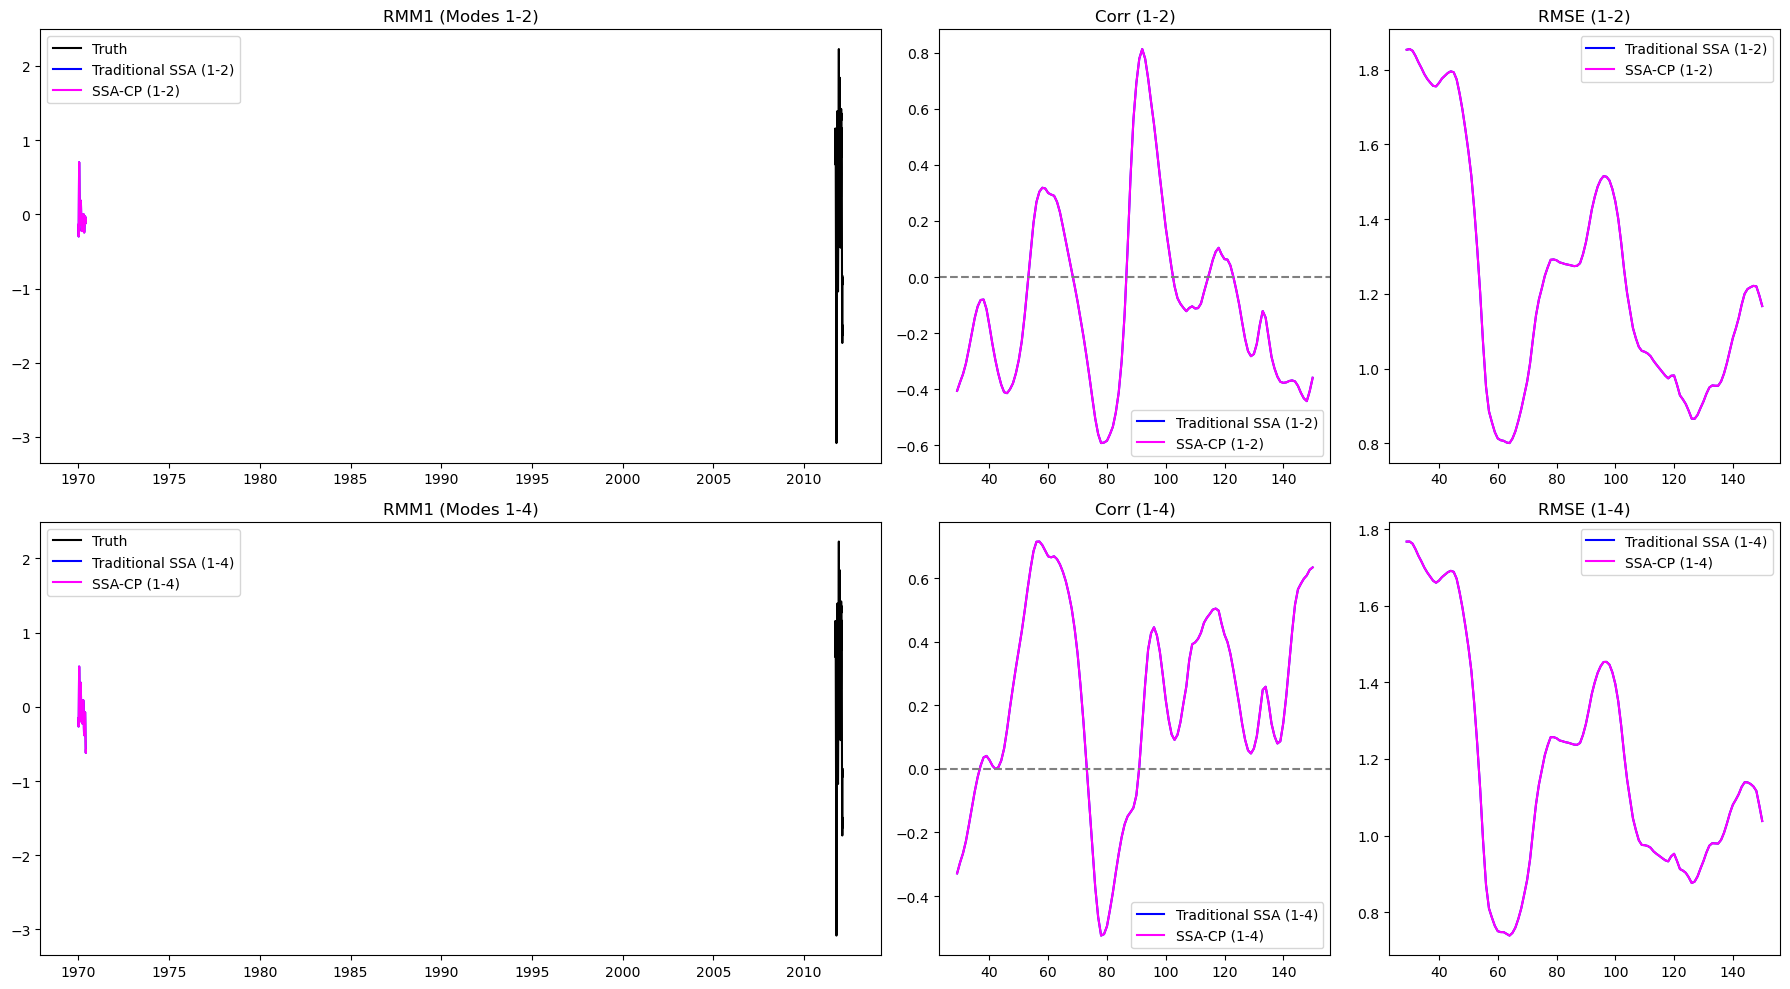

In [18]:
# Define the main parameters
embedding_window = 30
num_components_1_2 = 2
num_components_1_4 = 4
n_forecast = 50  # Forecast up to 50 days

# Generate reconstructed series for RMM1 using Traditional SSA, SSA-CP, and Ideal (Oracle) reconstruction
rmm_1 = df_subset["RMM1"]
traditional_reconstruction_1_2, _ = ssa_reconstruct(arr=df_subset["RMM1"], embedding_window=embedding_window, 
                                                    num_components=num_components_1_2, method="traditional")
ssa_cp_reconstruction_1_2, forecast_values_1_2 = ssa_reconstruct(arr=df_subset["RMM1"], embedding_window=embedding_window, 
                                                                 num_components=num_components_1_2, method="ssa_cp", 
                                                                 n_forecast=n_forecast)

traditional_reconstruction_1_4, _ = ssa_reconstruct(arr=df_subset["RMM1"], embedding_window=embedding_window, 
                                                    num_components=num_components_1_4, method="traditional")
ssa_cp_reconstruction_1_4, forecast_values_1_4 = ssa_reconstruct(arr=df_subset["RMM1"], embedding_window=embedding_window, 
                                                                 num_components=num_components_1_4, method="ssa_cp", 
                                                                 n_forecast=n_forecast)

# Calculate rolling correlations and RMSE between truth (ideal reconstruction) and Traditional SSA / SSA-CP
window_size = 30  # Rolling window size for metrics
correlation_1_2, rmse_1_2 = compute_rolling_metrics(rmm_1, traditional_reconstruction_1_2, window_size)
correlation_cp_1_2, rmse_cp_1_2 = compute_rolling_metrics(rmm_1, ssa_cp_reconstruction_1_2, window_size)

correlation_1_4, rmse_1_4 = compute_rolling_metrics(rmm_1, traditional_reconstruction_1_4, window_size)
correlation_cp_1_4, rmse_cp_1_4 = compute_rolling_metrics(rmm_1, ssa_cp_reconstruction_1_4, window_size)

# Plot setup similar to the figure in your image
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 4, figure=fig)

# (a) Plot RMM1 Reconstructed using components 1 and 2
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(df_subset["RMM1"], label="Truth", color="black")
ax1.plot(traditional_reconstruction_1_2, label="Traditional SSA (1-2)", color="blue")
ax1.plot(ssa_cp_reconstruction_1_2, label="SSA-CP (1-2)", color="magenta")
ax1.set_title("RMM1 (Modes 1-2)")
ax1.legend()

# (d) Plot RMM1 Reconstructed using components 1 through 4
ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(df_subset["RMM1"], label="Truth", color="black")
ax2.plot(traditional_reconstruction_1_4, label="Traditional SSA (1-4)", color="blue")
ax2.plot(ssa_cp_reconstruction_1_4, label="SSA-CP (1-4)", color="magenta")
ax2.set_title("RMM1 (Modes 1-4)")
ax2.legend()

# (b) Bivariate Pattern Correlation for Components 1-2
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(correlation_1_2, color="blue", label="Traditional SSA (1-2)")
ax3.plot(correlation_cp_1_2, color="magenta", label="SSA-CP (1-2)")
ax3.set_title("Corr (1-2)")
ax3.axhline(0, color="gray", linestyle="--")
ax3.legend()

# (c) RMSE for Components 1-2
ax4 = fig.add_subplot(gs[0, 3])
ax4.plot(rmse_1_2, color="blue", label="Traditional SSA (1-2)")
ax4.plot(rmse_cp_1_2, color="magenta", label="SSA-CP (1-2)")
ax4.set_title("RMSE (1-2)")
ax4.legend()

# (e) Bivariate Pattern Correlation for Components 1-4
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(correlation_1_4, color="blue", label="Traditional SSA (1-4)")
ax5.plot(correlation_cp_1_4, color="magenta", label="SSA-CP (1-4)")
ax5.set_title("Corr (1-4)")
ax5.axhline(0, color="gray", linestyle="--")
ax5.legend()

# (f) RMSE for Components 1-4
ax6 = fig.add_subplot(gs[1, 3])
ax6.plot(rmse_1_4, color="blue", label="Traditional SSA (1-4)")
ax6.plot(rmse_cp_1_4, color="magenta", label="SSA-CP (1-4)")
ax6.set_title("RMSE (1-4)")
ax6.legend()

plt.tight_layout()
plt.show()
